Ben Stadel's project for the CTA200H course. The goal of the project is to estimate 5 parameters of the GW150914 Binary Black Hole Merger using a Monte Carlo Chain applied to the posterior probability of the system. The 5 parameters we're estimating are the mass ratio q, the chirp mass M_c, the coalescence time t_c, the luminosity distance d_l and the cosine of the inclination cosi. At the end of the notebook there is also a histogram of the primary mass distributions of the first 10 black hole binary gravity wave detections, along with another plot of an interpolation of the distribution divided by mass^-2.2 . The results I got from the Monte Carlo Chain aren't particularly good or useful, but emcee is known for not being very good with gravtiational wave signals and the code all runs, so that's good enough for now.

In [2]:
pip install bilby

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: unyt 2.8.0 has a non-standard dependency specifier numpy>="1.13.0". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of unyt or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import pandas as pd
from gwpy.timeseries import TimeSeries
from pycbc import frame
from pycbc.waveform import get_fd_waveform
from pycbc.filter import highpass,resample_to_delta_t, resample
import tarfile
import h5py
from astropy import coordinates
from astropy import units as u
from scipy.interpolate import interp1d
from astropy.cosmology import Planck18
from pycbc.types.frequencyseries import FrequencySeries
import corner
from scipy.optimize import minimize
import bilby
from bilby.core.prior import Uniform, PowerLaw
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters
from scipy.integrate import quad
from gwpy.timeseries import TimeSeries

Matplotlib is building the font cache; this may take a moment.


ModuleNotFoundError: No module named 'pycbc'

In [28]:
def corner_plots(sampler, discard, thin, labels):
    '''Function to make corner plots showing the results of monte carlo run:
    sampler = emcee ensemble sampler
    discard = number of runs one wishes to discard at start of run, int
    thin = number of steps between saved points to get rid of correlation, int'''
    flat_samples = sampler.get_chain(discard=discard, thin=thin, flat=True)
    print(flat_samples.shape)
    labels = labels
    fig = corner.corner(
        flat_samples, labels=labels)
    
def plot_results(samples, labels):
    ''' Function to plot the results of the monte carlo chain
    samples = the chain returned by running the sampler'''
    fig, axes = plt.subplots(5, figsize=(10, 10), sharex=True)
    labels = labels
    for i in range(5):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")

In [67]:

def log_liklihood(q, Mc, t_c, d_l, cosi, h1, h1_psd):
    '''Function to define the logarithm of the likelihood function of the merger based on certain parameters:
    q = mass ratio, float
    Mc = chirp mass, float
    t_c = coalescence time, float
    d_l = luminosity distance, float
    cosi = cosine of inclination, float
    h1 = frequency series derived from gravitational wave signal detected at the LIGO Hanford observatory
    h1_psd = power spectral distribution from the observatory, in the form of a numpy array'''
    F_plus=-0.7483836192459883 # Values used as coefficients for constructed wave form, dependant on location of source and properties of detector
    F_cross=0.23744495842784608 
    # Generate waveform using inputted parameters, recieves plus and cross polarized waveforms
    mu_plus, mu_cross = get_fd_waveform(approximant="IMRPhenomXAS", mass1=Mc*(1+q)**(1/5)/q**(3/5), mass2=q**(3/5)*Mc*(1+1/q)**(1/5), 
                                        distance=d_l, inclination=np.arccos(cosi), f_lower=20, delta_f=1/4)
    mu_tot=F_plus*mu_plus+F_cross*mu_cross
    # Remove any frequencies outside of the 20-300 Hz range 
    mu_tot=resample.interpolate_complex_frequency(mu_tot, 1/4)
    low_index_mu = np.argmax(np.where(mu_tot.sample_frequencies < 20.))
    high_index_mu = np.argmax(np.where(mu_tot.sample_frequencies < 300.))
    mu_tot=mu_tot[low_index_mu:high_index_mu]
    # Set the time of the even to the coalescence time parameter
    mu_tot=mu_tot.cyclic_time_shift(t_c)
    # Calculate the liklehood function using h1, the psd and the generate waveform
    x=np.sum(np.abs(h1.data)**2/h1_psd)-np.sum(np.real(h1.data*mu_tot.data)/h1_psd)
    return x

def log_prior(q, Mc, t_c, d_l, cosi):
    '''Fucntion to define the prior probability of the parameters using a flat distribution where:
    q = mass ratio, float
    Mc = chirp mass, float
    t_c = coalescence time, float
    d_l = luminosity distance, float
    cosi = cosine of inclination, float'''
    if not 0.2<=q<=1 or not 25<=Mc<=35 or not -0.1<=t_c<=0.1 or not 10<=d_l<=800 or not -1<=cosi<=1:
        return -np.inf
    return 0

def log_prob(theta, h1, h1_psd):
    ''''Function that returns the unnormalized posterior probability
    theta = 5 X 100 array for 100 walkers in each 5 dimensions
    h1 = frequency series derived from gravitational wave signal detected at the LIGO Hanford observatory
    h1_psd = power spectral distribution from the observatory, in the form of a numpy array'''
    q, Mc, t_c, d_l, cosi = theta
    lprior = log_prior(q, Mc, t_c, d_l, cosi)
    # statement to handle when lprior returns negative infinite, so when the parameters are outside the desired domain
    if np.isfinite(lprior):
        return lprior + log_liklihood(q, Mc, t_c, d_l, cosi, h1, h1_psd)
    else:
        return lprior

def retrieve_psd():
    '''Function to open and return the file containing the psd data'''
    psd_file= pd.read_table("GWTC1_GW150914_PSDs.dat")
    freq=psd_file["# Freq (Hz)"]
    H1_PSD = psd_file["LIGO_Hanford_PSD (1/Hz)"]
    return freq, H1_PSD


def params5(steps):
    '''Function to estimate 5 parameters of the GW150914 merger event
    steps = number of desired steps in the Monte Carlo Chain, int'''
    time_of_event = 1126259462.43
    # read the strain data, pick the desired time frame, convert to a frequency series and resample to correct delta f, then narrow to 20-300 Hz
    h1=frame.read_frame("H-H1_GWOSC_4KHZ_R1-1126259447-32.gwf", channels="H1:GWOSC-4KHZ_R1_STRAIN")
    h1 = h1.cyclic_time_shift(time_of_event).crop(14,14)
    h1 = h1.to_frequencyseries()
    h1=resample.interpolate_complex_frequency(h1, 1/4)
    low_index = np.argmax(np.where(h1.sample_frequencies <= 20.))
    high_index = np.argmax(np.where(h1.sample_frequencies <= 300.))
    h1=h1[low_index:high_index]
    # Retrieve the corresponding psd and interpolate it to match the frequency spacing of the above frequency series
    freq, h1_psd = retrieve_psd()
    h1_interp = interp1d(freq.to_numpy(), h1_psd.to_numpy(), fill_value=0, bounds_error=False)
    h1_psd = h1_interp(np.arange(20, 300, 0.25))
    # Set the dimensions of the parameter space and the desired number of walkers
    ndim = 5  
    nwalkers = 100
    # Set the inital values for each walker
    p0 = np.array([np.random.uniform(0.2, 1 ,nwalkers), np.random.uniform(25,35,nwalkers), 
                    np.random.uniform(-0.1, 0.1, nwalkers), np.random.uniform(10,800, nwalkers), np.random.uniform(-1,1,nwalkers)])
    # Run the sampler, passing the number of walkers, dimensions, the log probability and the data as arguments
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(h1, h1_psd))
    state = sampler.run_mcmc(p0.T, steps, progress=True)
    samples = sampler.get_chain()
    return state, samples, sampler

#state2, samples2, sampler2 = params5(100)
state1, samples1, sampler1 = params5(2000)



100%|██████████| 2000/2000 [13:37<00:00,  2.45it/s]


In [ ]:
def bilby_attempt():
    time_of_event = 1126259462.43
    label = "GW150914"
    detectors = ["H1"]
    maximum_frequency = 300
    minimum_frequency = 20
    roll_off = 0.4  # Roll off duration of tukey window in seconds, default is 0.4s
    duration = 4  # Analysis segment duration
    post_trigger_duration = 2  # Time between trigger time and end of segment
    end_time = time_of_event + post_trigger_duration
    start_time = end_time - duration
    prior = bilby.core.prior.PriorDict()
    prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=25,maximum=35)
    prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.2, maximum=1)
    prior['phase'] = 0
    prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
    prior['theta_jn'] =  Uniform(name="theta_jn", minimum=0, maximum=np.pi)
    prior['a_1'] =  0.0
    prior['a_2'] =  0.0
    prior['tilt_1'] =  0.0
    prior['tilt_2'] =  0.0
    prior['phi_12'] =  0.0
    prior['phi_jl'] =  0.0
    prior['dec'] =  -1.2232
    prior['ra'] =  2.19432
    prior['psi'] =  0.532268
    prior['luminosity_distance'] = Uniform(name='luminosity_distance', minimum=10, maximum=2000, unit='Mpc', latex_label='$d_L$')
    psd_duration = 1024
    psd_start_time = start_time - psd_duration
    psd_end_time = start_time
    ifo_list = bilby.gw.detector.InterferometerList([])
    for det in detectors:
        ifo = bilby.gw.detector.get_empty_interferometer(det)
        data = TimeSeries.fetch_open_data(det, start_time, end_time)
        ifo.strain_data.set_from_gwpy_timeseries(data)
        psd_data = TimeSeries.fetch_open_data(det, psd_start_time, psd_end_time)
        psd_alpha = 2 * roll_off / duration
        psd = psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
        ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
            frequency_array=psd.frequencies.value, psd_array=psd.value)
        ifo.maximum_frequency = maximum_frequency
        ifo.minimum_frequency = minimum_frequency
        ifo_list.append(ifo)
    waveform_generator = bilby.gw.WaveformGenerator(frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                        waveform_arguments={"waveform_approximant": "IMRPhenomXAS","reference_frequency": 20,},)
    likelihood = bilby.gw.likelihood.GravitationalWaveTransient(ifo_list, waveform_generator,
                priors=prior,time_marginalization=False, 
                distance_marginalization=False)
    result = bilby.run_sampler(likelihood, prior, sampler="dynesty", label=label, nlive=1000, check_point_delta_t=600, check_point_plot=True,
            npool=1, conversion_function=bilby.gw.conversion.generate_all_bbh_parameters)
    result.plot_corner()
    return result

result = bilby_attempt()


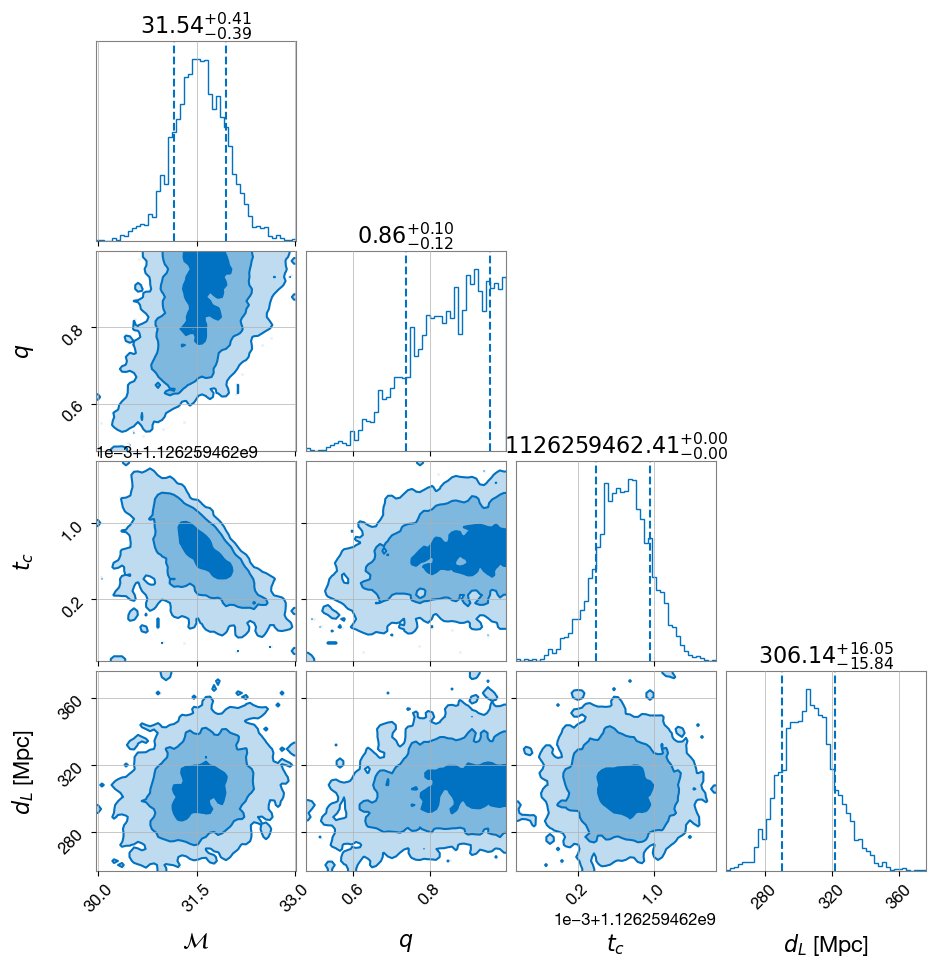

In [115]:
result.plot_corner()

GWTC-1_sample_release/GW150914_GWTC-1.hdf5
GWTC-1_sample_release/GW151012_GWTC-1.hdf5
GWTC-1_sample_release/GW151226_GWTC-1.hdf5
GWTC-1_sample_release/GW170104_GWTC-1.hdf5


/var/folders/fz/gmq_shgd1r33xrr38gysz1wh0000gn/T/ipykernel_1421/2267872872.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  logdenom = np.log(quad(integrand, 5.1, 95, args=(alpha, M_max))[0])
/var/folders/fz/gmq_shgd1r33xrr38gysz1wh0000gn/T/ipykernel_1421/2267872872.py:71: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  logdenom = np.log(quad(integrand, 5.1, 95, args=(alpha, M_max))[0])
/var/folders/fz/gmq_shgd1r33xrr38gysz1wh0000gn/T/ipykernel_1421/226787287

(3300, 2)


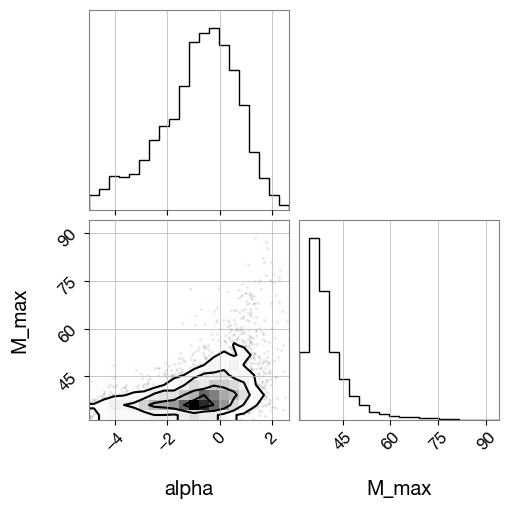

In [51]:
def hierarchy(steps):
    path = "GWTC-1_sample_release"
    files = tarfile.open(path+".tar", "r")
    files.extractall()
    names = files.getnames()[:4]
    #del names[8]
    zarr = np.geomspace(0.0001, 5, 100000)
    dlarr = Planck18.luminosity_distance(zarr).value
    dl_to_z = interp1d(dlarr, zarr)
    shortest_length = np.inf
    masses={}
    for name in names:
        print(name)
        file = h5py.File(name, "r")
        m1_detector = file['Overall_posterior']['m1_detector_frame_Msun']
        m2_detector = file['Overall_posterior']['m2_detector_frame_Msun']
        z= dl_to_z(file['Overall_posterior']['luminosity_distance_Mpc'])
        primary_mass = m1_detector/(1+z)
        secondary_mass = m2_detector/(1+z)
        shortest_length=measure_length(shortest_length, len(primary_mass))
        mass_list=np.column_stack([primary_mass, secondary_mass])
        masses[name]=mass_list
    primary_masses_array, secondary_masses_array = restructure(masses, shortest_length, names)
    ndim = 2  
    nwalkers = 100
    p0 = np.array([np.random.uniform(-5, 10 ,nwalkers), np.random.uniform(10,100,nwalkers)])
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_hier, args=(primary_masses_array, secondary_masses_array))
    state = sampler.run_mcmc(p0.T, steps, progress=True)
    samples = sampler.get_chain()
    return state, samples, sampler

def restructure(masses, length, names):
    primary_array = np.zeros((4, length))
    secondary_array = np.zeros((4, length))
    for i in range(len(names)):
        masses_list = masses[names[i]]
        if len(masses_list)>length:
                masses_list=masses_list[np.random.choice(masses_list.shape[0], length, replace=False), :]
                #print(masses_list)
        primary_array[i] = masses_list[:,0]
        secondary_array[i] = masses_list[:,1]
    return primary_array, secondary_array
                

def measure_length(shortest_length, length):
    if length<shortest_length:
        return length
    else:
        return shortest_length
    
    
def log_prob_hier(theta, m_1, m_2):
    alpha, M_max = theta
    lprior = log_prior_hier(alpha, M_max)
    # statement to handle when lprior returns negative infinite, so when the parameters are outside the desired domain
    if np.isfinite(lprior):
        return lprior + log_likelihood_hier(alpha, M_max, m_1, m_2)
    else:
        return lprior
    
def log_prior_hier(alpha, M_max):
    if not -5<=alpha<=10 or not 10<M_max<100:
        return -np.inf
    return 0

def log_likelihood_hier(alpha, M_max, m_1, m_2):
    lognum=np.zeros(10)
    for i in range(len(m_1)):
        lognum[i] = mean_function(alpha, M_max, m_1[i])
    log_sum = np.sum(lognum)
    logdenom = np.log(quad(integrand, 5.1, 95, args=(alpha, M_max))[0])
    return log_sum-len(m_1)*logdenom

def mean_function(alpha, M_max, m_1):
    return np.log(np.mean(m_1**(-alpha)*np.heaviside(M_max-m_1, 1)/(np.minimum(m_1, 100-m_1)-5)))

def integrand(m_1, alpha, M_max):
    #norm = quad(norm_integrand, 5.1, 95, args=(alpha, M_max))[0]
    #N=1/(norm)**(1/2)
    return m_1**(2.2-alpha)*np.heaviside(M_max-m_1, 1)/(np.minimum(m_1, 100-m_1)-5)

def norm_integrand(m_1, alpha, M_max):
    return (m_1**(-alpha)*np.heaviside(M_max-m_1, 1)/(np.minimum(m_1, 100-m_1)-5))**2
    

hier_state, hier_samples, hier_sampler = hierarchy(1000)
corner_plots(hier_sampler, 500, 15, ["alpha", "M_max"])

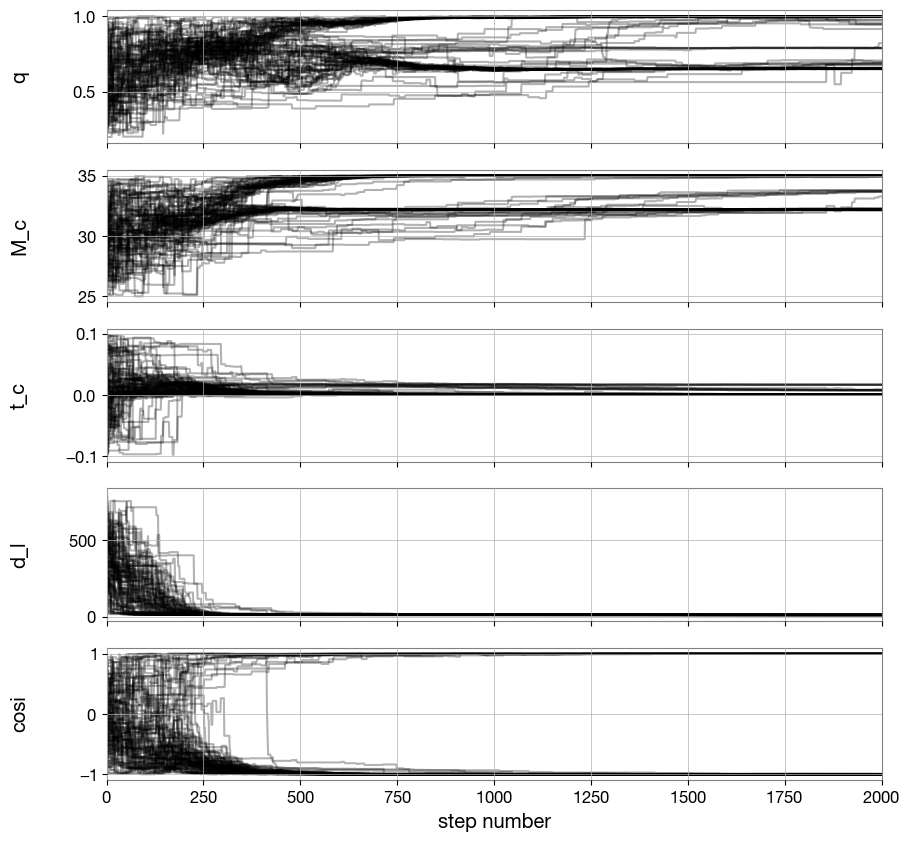

In [68]:
plot_results(samples1, ["q", "M_c", "t_c", "d_l", "cosi"])

(8300, 5)


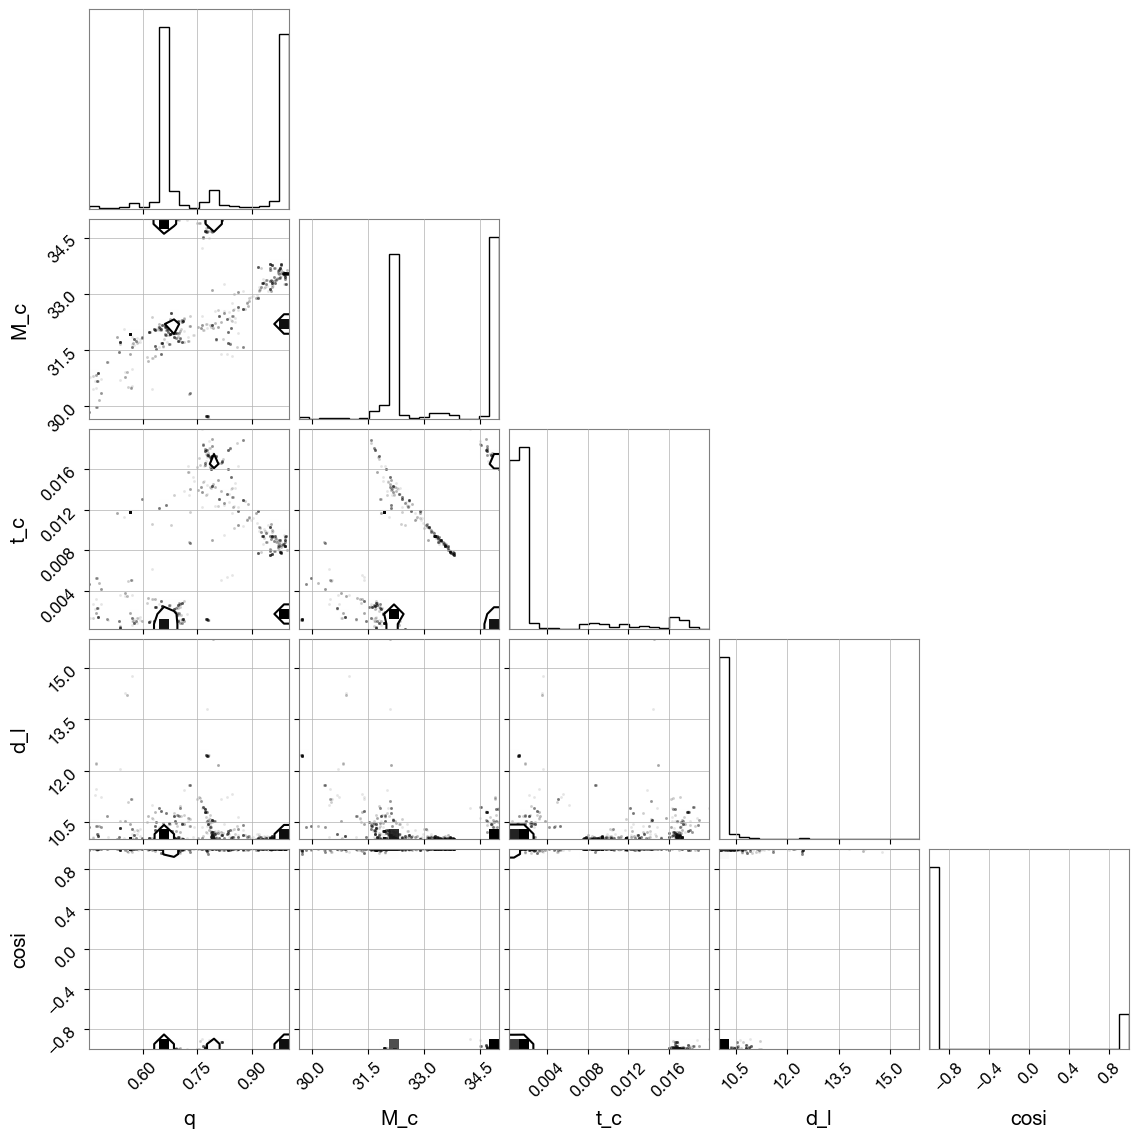

In [69]:
corner_plots(sampler1, 750, 15, ["q", "M_c", "t_c", "d_l", "cosi"])

GWTC-1_sample_release/GW150914_GWTC-1.hdf5
GWTC-1_sample_release/GW151012_GWTC-1.hdf5
GWTC-1_sample_release/GW151226_GWTC-1.hdf5
GWTC-1_sample_release/GW170104_GWTC-1.hdf5
GWTC-1_sample_release/GW170608_GWTC-1.hdf5
GWTC-1_sample_release/GW170729_GWTC-1.hdf5
GWTC-1_sample_release/GW170809_GWTC-1.hdf5
GWTC-1_sample_release/GW170814_GWTC-1.hdf5
GWTC-1_sample_release/GW170818_GWTC-1.hdf5
GWTC-1_sample_release/GW170823_GWTC-1.hdf5
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1903.3906601055946
        x: [-5.930e+00  9.877e+01]
      nit: 7
      jac: [ 1.373e-04 -1.526e-04]
 hess_inv: [[ 1.985e-04 -2.675e-03]
            [-2.675e-03  3.654e-02]]
     nfev: 110
     njev: 33
-5.930329306658384


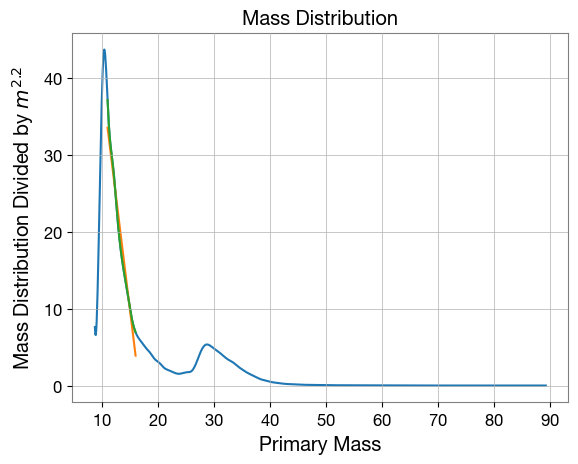

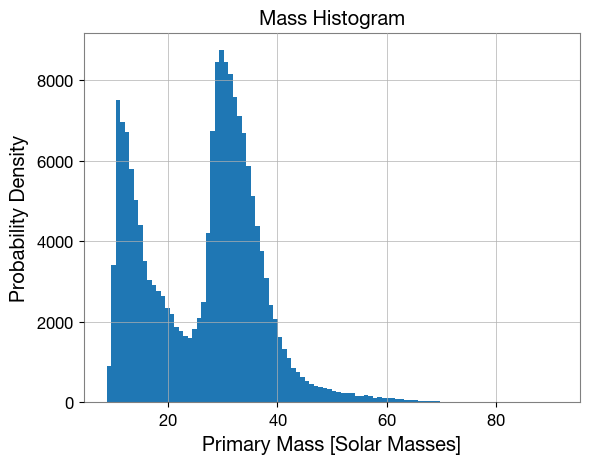

In [59]:
def histogram():
    ''''Function to plot histogram of primary mass distribution of first 10 black hole merger detections, 
    as well as an interpolated histogram where the distribution is divided by m^2.2'''
    # open file and remove 2 extra datasets from the 10 I want
    # Need to download GWTC-1_sample_release.tar.gz from https://dcc.ligo.org/LIGO-P1800370/public, as github wouldnt let me upload it since its too big
    path = "GWTC-1_sample_release"
    files = tarfile.open(path+".tar", "r")
    files.extractall()
    names = files.getnames()[:-1]
    del names[8]
    # Create interpolated function to convert luminosity distance to redshift
    zarr = np.geomspace(0.0001, 5, 100000)
    dlarr = Planck18.luminosity_distance(zarr).value
    dl_to_z = interp1d(dlarr, zarr)
    masses=[]#, dtype=np.array)
    # for each detection, convert the detector fram mass to object frame mass and add to a list
    for name in names:
        print(name)
        file = h5py.File(name, "r")
        mass_detector = file['Overall_posterior']['m1_detector_frame_Msun']
        z= dl_to_z(file['Overall_posterior']['luminosity_distance_Mpc'])
        mass=mass_detector/(1+z)
        masses.append(mass)
    # Convert the multidimensioanl list into a oen dimensioanl list
    mass_distri=flatten(masses)
    values, edges=np.histogram(mass_distri, bins=100)
    # Create interpolation to divide
    func=interp1d(edges[:-1], values, kind="cubic") 
    m=np.linspace(np.min(mass_distri), np.max(mass_distri)-2, 1000)
    #print(m)
    mfit=np.linspace(11,16, 1000)
    y=func(mfit)/mfit**2.2
    m_1, b_1 = -3, 20
    results = minimize(loss, [m_1, b_1], args=(mfit, y))
    results2 =np.polyfit(mfit, y, 1)[0]
    print(results)
    print(results2)
    plt.plot(m, func(m)/m**2.2)
    plt.plot(mfit, results.x[0]*(mfit)+results.x[1])
    plt.plot(mfit, y)
    plt.title("Mass Distribution")
    plt.xlabel("Primary Mass")
    plt.ylabel("Mass Distribution Divided by $m^{2.2}$")
    #plt.semilogy()

    plt.show()
    plt.hist(mass_distri, bins=100)
    plt.title("Mass Histogram")
    plt.xlabel("Primary Mass [Solar Masses]")
    plt.ylabel("Probability Density")

def flatten(xss):
    '''Function to flatten multi-dimensional list into a one dimensional list
    xss = multidimensional list we wisht to flatten'''
    return [x for xs in xss for x in xs]

def loss(theta, x, y):
    """A simple loss function as a function of parameters `theta`."""
    
    m, b = theta  # reassign parameters
    ypred = m * x + b
    resid = (ypred - y)**(2)
    
    return np.sum(resid)

histogram()
